In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error


%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import requests
import time
import datetime

In [2]:
CURRENCIES = {
    'Bitcoin' : 'BTC', 
    'Ethereum' : 'ETH', 
    'Litecoin' : 'LTC',
    'AdEx' : 'ADX', 
    'Substratum' : 'SUB',
    'Ripple' : 'XRP',
    'NEO' : 'NEO',
    'IOTA' : 'IOT',
    'Monero' : 'XMR',
             }
TARGET_CURRENCY = 'USD'

In [3]:
PRICE_HISTORY_BASE_URL = 'https://min-api.cryptocompare.com/data/histoday'
AGGREGATED_EXCHANGE = 'CCCAGG'
KRAKEN = 'KRAKEN'
NB_DAYS = 200
REQUEST_PARAMS = '?fsym={source_currency}&tsym={target_currency}&limit=' + str(NB_DAYS) + '&aggregate=1&e=' + KRAKEN # '&allData=1'
TEMPLATE_REQUEST_URL = PRICE_HISTORY_BASE_URL + REQUEST_PARAMS

In [4]:
# Obtain historical data from the beginning of time for each currency
currency_dataframe = {}
for currency, symbol in CURRENCIES.items():
    request_url = TEMPLATE_REQUEST_URL.format(source_currency = symbol, target_currency = TARGET_CURRENCY)
    print('Fetching historical market data for {} ({} -> {}) ....'.format(currency, symbol, TARGET_CURRENCY))
    print('Request URL :', request_url)
    json_response = requests.get(url = request_url).json()
    if json_response['Response'] == 'Error':
        print('Failed to fetch historical market data for {} ({} -> {}) !, Error Message : {}'
              .format(currency, symbol, TARGET_CURRENCY, json_response['Message']))
    else:
        # print(json_response)
        df = pd.DataFrame(json_response['Data'])
        # convert time (unix timestamp) to date
        df['date'] = pd.to_datetime(df['time'], unit = 's')
        # drop time column
        df.drop('time', axis = 1, inplace = True)
        # set date column as index
        df.set_index('date', inplace = True)
        
        # volumefrom : trading volume of source currency traded (ex: BTC)
        # volumeto : trading volume of target currency traded (ex: USD)
        # average price of 1 unit of the source currency in the target currency = volumeto / volumefrom
        df.rename(columns = {'open': 'market_open', 'close': 'market_close',
                             'low': 'market_low', 'high': 'market_high',
                             'volumefrom': 'trading_volume_source_currency', 
                             'volumeto': 'trading_volume_target_currency'}, inplace = True)
        currency_dataframe[currency] = df
        print('Successfully fetched historical market data for {} !'.format(currency, symbol))
    # sleep for 1s to avoid hitting max rate limit per second
    time.sleep(1)
        

Fetching historical market data for Bitcoin (BTC -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=200&aggregate=1&e=KRAKEN
Successfully fetched historical market data for Bitcoin !
Fetching historical market data for Ethereum (ETH -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&limit=200&aggregate=1&e=KRAKEN
Successfully fetched historical market data for Ethereum !
Fetching historical market data for Litecoin (LTC -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=LTC&tsym=USD&limit=200&aggregate=1&e=KRAKEN
Successfully fetched historical market data for Litecoin !
Fetching historical market data for AdEx (ADX -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=ADX&tsym=USD&limit=200&aggregate=1&e=KRAKEN
Failed to fetch historical market data for AdEx (ADX -> USD) !, Error Message : e param is not valid the market does not exist for th

In [24]:
def plot_bolligner(currency, df):
    # set style, empty figure and axes
    # plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    # Get index values for the X axis for DataFrame
    x_axis = df.index.get_level_values(0)

    # Plot shaded 21 Day Bollinger Band
    ax.fill_between(x_axis, df['upper_band'], df['lower_band'], color='grey')

    # Plot Price and Moving Averages
    ax.plot(x_axis, df[price_column], color='blue', lw=2)
    ax.plot(x_axis, df['mean_' + price_column], color='black', lw=2)

    # Set Title & Show the Image
    ax.set_title(str(window_size) + ' Day Bollinger Band For ' + currency)
    ax.set_xlabel('Date (Year/Month)')
    ax.set_ylabel('Price (' + TARGET_CURRENCY + ')')
    ax.legend()
    plt.show();

In [25]:
price_column = 'market_close'
window_size = 21
band_multiplier = 2

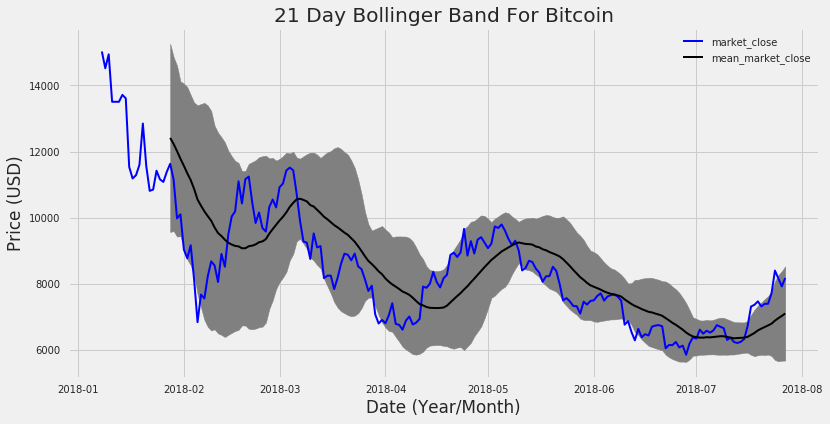

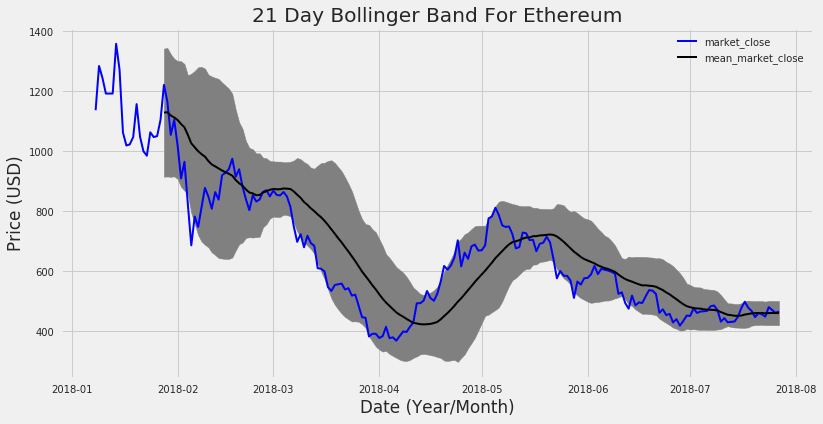

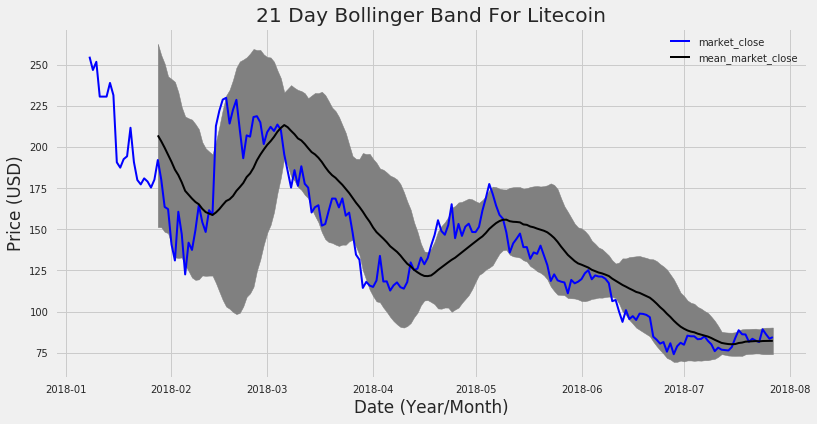

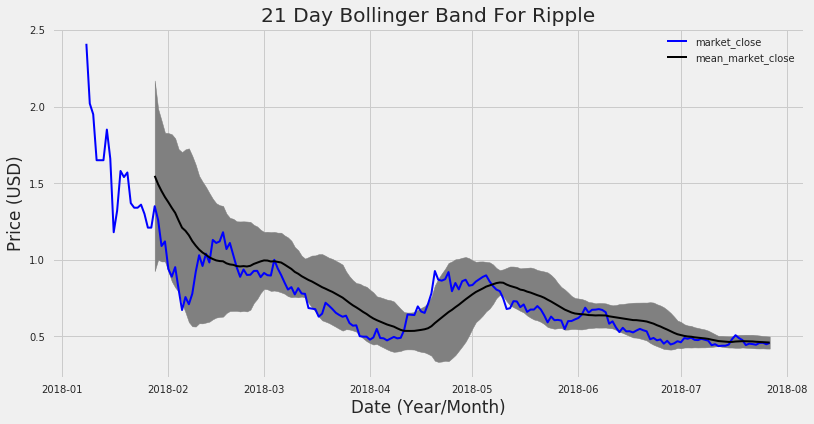

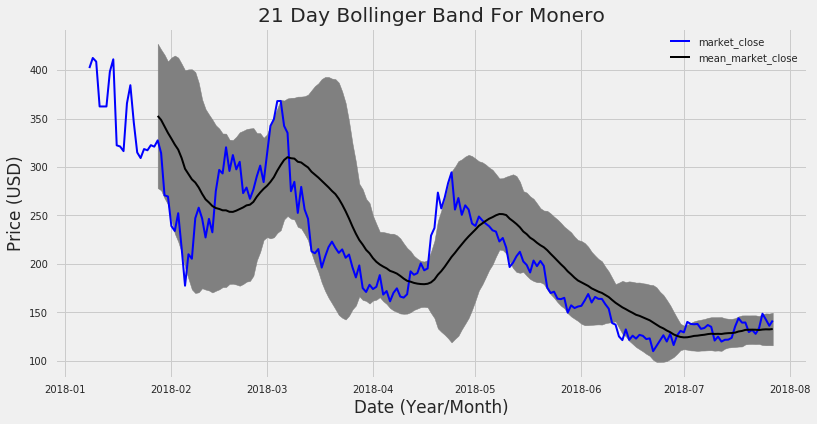

In [26]:
# Compute and Plot Bolligner Bands for all currencies
for currency, df in currency_dataframe.items():
    df['mean_' + price_column] = df[price_column].rolling(window=window_size).mean()
    df['std_' + price_column] = df[price_column].rolling(window=window_size).std()
    df['upper_band'] = df['mean_' + price_column] + band_multiplier * df['std_' + price_column]
    df['lower_band'] = df['mean_' + price_column] - band_multiplier * df['std_' + price_column]
    
    plot_bolligner(currency, df)
    

In [5]:
df = currency_dataframe['Bitcoin']

In [6]:
df.head()

,market_close,market_high,market_low,market_open,trading_volume_source_currency,trading_volume_target_currency
date,,,,,,
2018-01-08,15022.6,16130.1,14259.9,16128.4,3434.09,52090600.04
2018-01-09,14516.6,15440.7,14230.7,15022.6,2992.06,44550151.16
2018-01-10,14937.6,14979.0,13525.0,14516.6,3396.59,48191581.71
2018-01-11,13503.4,15055.0,12848.0,14937.6,1991.54,27096334.20
2018-01-12,13503.4,13503.4,13503.4,13503.4,0.00,0.00


In [7]:
df.describe()

,market_close,market_high,market_low,market_open,trading_volume_source_currency,trading_volume_target_currency
count,201.000000,201.000000,201.000000,201.000000,201.000000,2.010000e+02
mean,8588.321393,8916.079104,8248.006965,8632.316915,6774.115174,5.812430e+07
std,1897.076726,2039.942005,1776.779671,1981.987818,4504.134216,3.857976e+07
min,5858.600000,6161.100000,5650.000000,5858.600000,0.000000,0.000000e+00
25%,7080.100000,7447.900000,6773.900000,7080.100000,3636.800000,2.854193e+07
50%,8233.800000,8500.000000,7902.000000,8248.600000,5351.460000,4.840898e+07
75%,9526.200000,9799.900000,9165.000000,9580.000000,9117.070000,8.087972e+07
max,15022.600000,16130.100000,14259.900000,16128.400000,28799.430000,1.951901e+08


In [8]:
df.shape

(201, 6)

In [9]:
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_date

'2018-07-27'

In [19]:
df['mean_' + price_column] = df[price_column].rolling(window=window_size).mean()
df['std_' + price_column] = df[price_column].rolling(window=window_size).std()
df['upper_band'] = df['mean_' + price_column] + band_multiplier * df['std_' + price_column]
df['lower_band'] = df['mean_' + price_column] - band_multiplier * df['std_' + price_column]

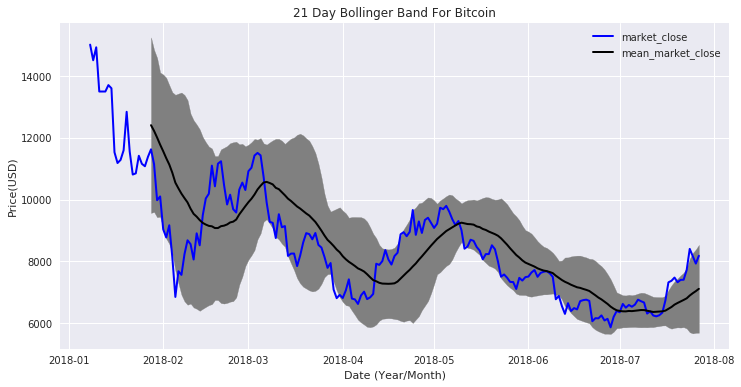

In [22]:
# set style, empty figure and axes
# plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

# Get index values for the X axis for DataFrame
x_axis = df.index.get_level_values(0)

# Plot shaded 21 Day Bollinger Band
ax.fill_between(x_axis, df['upper_band'], df['lower_band'], color='grey')

# Plot Price and Moving Averages
ax.plot(x_axis, df[price_column], color='blue', lw=2)
ax.plot(x_axis, df['mean_' + price_column], color='black', lw=2)

# Set Title & Show the Image
ax.set_title(str(window_size) + ' Day Bollinger Band For Bitcoin')
ax.set_xlabel('Date (Year/Month)')
ax.set_ylabel('Price (' + TARGET_CURRENCY + ')')
ax.legend()
plt.show();